# YELP Reviews Predictor

In this NLP project we will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. We will utilize the pipeline methods for more complex tasks.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

Let's get started! 

## Imports
 

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

**We are reading using the Yelp review data from Kaggle into a dataframe called yelp.**

In [7]:
yelp = pd.read_csv('yelp.csv')

** Let's explore the data by Checking the head, info , and describe methods on yelp.**

In [8]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [9]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [10]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


** We'll Create a new column called "text length" which is the number of words in the text column.**

In [11]:
yelp['text length'] = yelp['text'].apply(len)

# EDA

Let's explore the data

** using seaborn we'll try to make sense of the data at hand. **

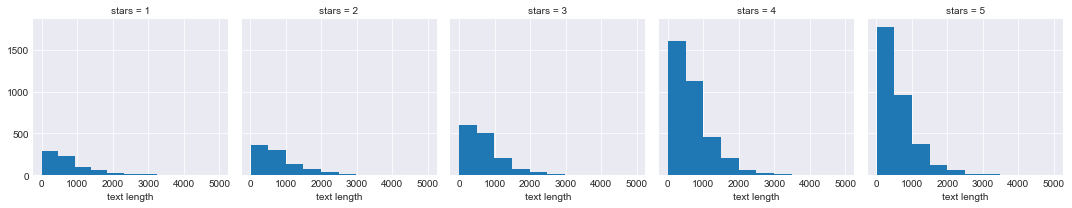

In [12]:
sns.set_style('darkgrid')
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'text length')

**boxplot of text length for each star category.**

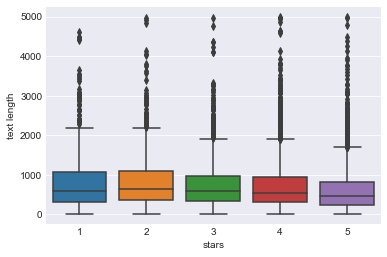

In [13]:
sns.boxplot(x = 'stars', y = 'text length', data = yelp)

**countplot of the number of occurrences for each type of star rating.**

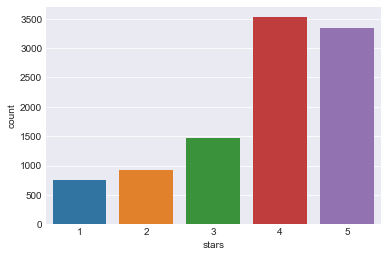

In [14]:
sns.countplot(x = 'stars', data = yelp)

** mean values of the numerical columns**

In [15]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


** Correlation of the mean values **

In [16]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


**heatmap based off that .corr() dataframe:**

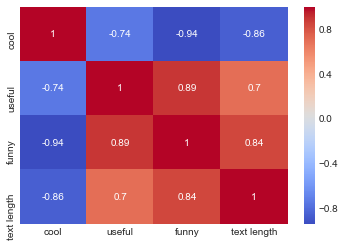

In [17]:
sns.heatmap(stars.corr(), cmap='coolwarm', annot=True)

## NLP Classification Task

**We'll create a dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.**

In [18]:
yelp_class = yelp[(yelp.stars==1)|(yelp.stars==5)]

** Lets get our features and targets **

In [19]:
x = yelp_class['text']
y = yelp_class['stars']

**Import CountVectorizer and create a CountVectorizer object to convert the text documents into a matrix of token counts.**

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

** We'll fit the CountVectorizer object to our text.**

In [21]:
x = cv.fit_transform(x)

# Using Text Processing

** Import TfidfTransformer from sklearn. **

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

** Import Pipeline from sklearn. **

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

** Now we will create a pipeline with the following steps:CountVectorizer(), TfidfTransformer(),LogisticRegression()**

In [44]:
pipeline = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('classifier', LogisticRegression())
])

### Train Test Split

** train test split on the yelp_class object.**

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x = yelp_class['text']
y = yelp_class['stars']
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.3,random_state=101)

** Now we will fit the pipeline to the training data. **

In [28]:
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

### Predictions and Evaluation

** Now using the pipeline to predict from the X_test. We can interpret the results by creating a classification report and confusion matrix **

In [31]:
predictions = pipeline.predict(x_test)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 98 130]
 [  2 996]]
             precision    recall  f1-score   support

          1       0.98      0.43      0.60       228
          5       0.88      1.00      0.94       998

avg / total       0.90      0.89      0.87      1226



** Lets Check the Accuracy of the model ** 

In [43]:
cm = confusion_matrix(y_test, predictions)
accuracy = ((cm[0,0] + cm[1,1]) / (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) * 100 ) 
print('Accuracy of the model is: {} % '.format(round(accuracy,2)))

Accuracy of the model is: 89.23 % 


** Thank you !! **